This notebook demonstrate the ROI calibration based on learned user-drawn bounding boxes.

In [19]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [20]:
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor

def get_model(
        num_classes: int | None = None,
        num_keypoints: int | None = None
    ):
    # Load a pre-trained Keypoint RCNN model
    weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
    model = keypointrcnn_resnet50_fpn(weights=weights)

    # Modify the model's head
    if num_classes is not None:
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    if num_keypoints is not None:
        in_features = model.roi_heads.keypoint_predictor.kps_score_lowres.in_channels
        model.roi_heads.keypoint_predictor = KeypointRCNNPredictor(in_features, num_keypoints)

    return model

from safetensors.torch import load_model

# Load trained model weights
model = get_model(num_classes=2, num_keypoints=14).to(device)
load_model(model, "models/2025-12-12/15-07-04/epoch-48/model.safetensors", device=device)

(set(), [])

In [21]:
from roi_calib.custom.trousers2 import TrousersROICalibrator
calibrator = TrousersROICalibrator(
    model=model,
    transforms=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT.transforms(),
    score_thres=0.85,
    device=device
)

In [22]:
def plt_draw_rect(image, xyxy_multi):
    _, ax = plt.subplots()
    ax.imshow(image)

    for x1, y1, x2, y2 in xyxy_multi:
        w = x2 - x1
        h = y2 - y1

        rect = patches.Rectangle(
            xy=(x1, y1),
            width=w,
            height=h,
            linewidth=2,
            fill=False,
            edgecolor="b",
            facecolor=None
        )
        ax.add_patch(rect)

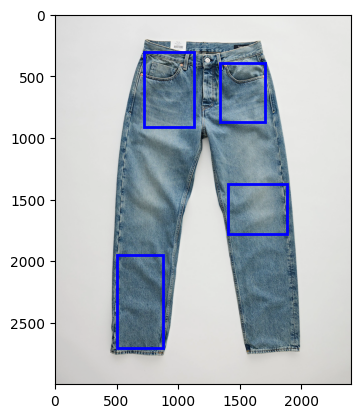

In [23]:
ref_image = Image.open("images/jeans/001.jpg").convert("RGB")
user_drawn_roi = {
    "roi_1": [721, 301, 1129, 913],
    "roi_2": [1341, 393, 1709, 873],
    "roi_3": [1401, 1377, 1885, 1777],
    "roi_4": [501, 1953, 881, 2705],
}
plt_draw_rect(ref_image, user_drawn_roi.values())

Calibrating 4 ROIs...
 - Learned 'roi_1': attached to Waist_Left
 - Learned 'roi_2': attached to Waist_Right
 - Learned 'roi_3': attached to R_Thigh_Lower
 - Learned 'roi_4': attached to L_Calf_Lower


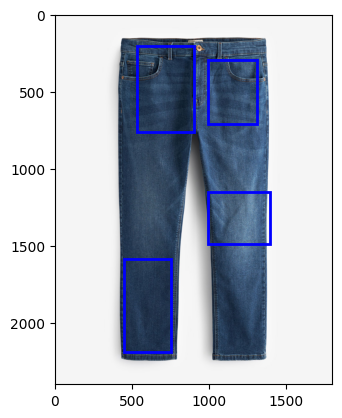

In [24]:
calibrator.learn_rois(ref_image, user_drawn_roi, reset_learned=True)

target_image = Image.open("images/jeans/002.jpg").convert("RGB")
target_rois = calibrator.predict_rois(target_image)
plt_draw_rect(target_image, target_rois.values())